In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/race/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/race/input/train.csv
/content/race/input/test.csv


In [12]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import warnings
np.random.seed(123)
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import csv

In [13]:
#train_dataset = pd.read_csv("/content/race/input/train.csv",)
train_dataset = pd.read_csv("/content/race/input/train.csv")
train_dataset
#with open("/content/race/input/train.csv",encode="utf-8") as f:


,Unnamed: 0,article,class
0,0,my husband is a born shopper . he loves to loo...,high
1,1,tea drinking was common in china for nearly on...,high
2,2,"once upon a time , there was a scholar who wan...",high
3,3,when newspapers and radio describe the damage ...,high
4,4,below is a page adapted from about wikipedia o...,high
...,...,...,...
25132,25132,joe brown had a shop . he sold meat in his sho...,middle
25133,25133,if you do not use your arms or your legs for s...,middle
25134,25134,mrs. jones is waiting for an important telepho...,middle
25135,25135,new york is a very large city with 8 million p...,middle


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

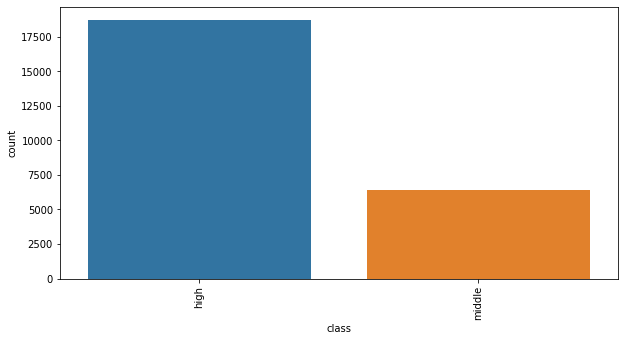

In [14]:
# Visualizing the variable - 'year'
plt.figure(figsize = (10,5))
plt.xticks(rotation=90)
sns.countplot(train_dataset['class'])

In [15]:
from fastai.text import *

In [16]:
from pathlib import Path

In [17]:
path = Path('/content/race/input/')

In [18]:
%%time
data_lm = TextLMDataBunch.from_csv(path,'train.csv', text_cols = "article", label_cols = "class")

CPU times: user 3.93 s, sys: 621 ms, total: 4.55 s
Wall time: 35.7 s


In [19]:
%%time
data_clas = TextClasDataBunch.from_csv(path, 'train.csv', vocab=data_lm.train_ds.vocab, bs=32, text_cols = "article", label_cols = "class")

CPU times: user 5.13 s, sys: 683 ms, total: 5.81 s
Wall time: 37 s


In [20]:
data_clas

TextClasDataBunch;

Train: LabelList (20109 items)
x: TextList
xxbos paris in the springtime was , is and always will be , something rather special . why not experience it for yourself with this excellent break for four days ? this attractive city has something to offer to everyone and with prices at just ps129 . your break begins with comfortable bus transfer from local pick - up points and travel to paris is via cross - channel ferry , arriving at your hotel in the evening . the ibis is an excellent quality hotel with private equipments in all rooms : satellite tv , radio , telephone and alarm clock . it has a bar and restaurant and is situated about two miles south of notre dame enabling you to explore paris with ease . the following day , after continental breakfast ( included ) , the bus takes you on a comprehensive sightseeing tour of the city , during which you will see the eiffel tower , champs elysees , l'arc de triomphe , the louvre , in fact almost every famous landmark you 

In [21]:
bs=16

In [22]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [23]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.332078,4.042467,0.275956,07:30


In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.140218,3.989223,0.282471,08:46
1,3.980434,3.826196,0.298410,08:47
2,3.653732,3.769302,0.305054,08:47


In [25]:
learn.predict("This is a review about", n_words=10)


'This is a review about the effect of each eye , earning attention on the'

In [26]:
learn.predict("This game is one of the ", n_words=10)

'This game is one of the  greatest games for men in history , one of the'

In [27]:
learn.model_dir = Path('/content/race/working/')

In [28]:
learn.save(file = Path('language_model'))
learn.save_encoder(Path('language_model_encoder'))

In [29]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.model_dir = Path('/content/race/working/')
learn.load_encoder('language_model_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (20109 items)
x: TextList
xxbos paris in the springtime was , is and always will be , something rather special . why not experience it for yourself with this excellent break for four days ? this attractive city has something to offer to everyone and with prices at just ps129 . your break begins with comfortable bus transfer from local pick - up points and travel to paris is via cross - channel ferry , arriving at your hotel in the evening . the ibis is an excellent quality hotel with private equipments in all rooms : satellite tv , radio , telephone and alarm clock . it has a bar and restaurant and is situated about two miles south of notre dame enabling you to explore paris with ease . the following day , after continental breakfast ( included ) , the bus takes you on a comprehensive sightseeing tour of the city , during which you will see the eiffel tower , champs elysees , l'arc de triomphe , the louvre , in fact almost every famo

In [30]:
data_clas.show_batch()

text,target
"xxbos parents divorced , little buddy was in the care of his mother 's large alabama family . over the years , buddy seldom saw either of his parents . but he was happy where he was and he had many kindly s , among whom miss sook was by far his best friend . before christmas , buddy 's father had managed to get legal custody of him for",high
"xxbos a long time ago , there lived a poor man whose real name has been forgotten . he was little and old and his face was wrinkled , and that was why his friends called him mr . vinegar . his wife was also little and old , and they lived in a little old cottage at the back of a little old field . ` ` john ,",high
"xxbos my daughter allie is leaving for college in a week . her room is piled with shopping bags filled with blankets , towels , jeans , sweaters . she wo n't talk about going . i say , ` ` i ' m going to miss you , '' and she gives me one of her looks and leaves the room . another time i say , in a",high
"xxbos today i was at the mall waiting for friends , when a lady wearing a knit hat and a sweater came up to me and , shivering , said , ` ` i ' m homeless . would you mind buying me some food ? '' in that split second , everything i 'd learned since kindergarten flashed through my mind . do n't talk to strangers ... be",high
"xxbos old behrman was a painter who lived on the ground floor of the apartment building . for years , he had always been planning to paint a work of art , but had never yet begun it . he earned a little money by serving as a model to artists who could not pay for a professional model . he was a fierce , little , old man who",high


In [31]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.467537,0.302752,0.875099,01:23


In [32]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.407520,0.312172,0.864757,02:50
1,0.352568,0.280184,0.891010,02:42
2,0.277036,0.255863,0.894193,02:50


In [33]:
learn.predict('This game is absolute shit! Dont waste your money!')

(Category tensor(1), tensor(1), tensor([0.3961, 0.6039]))

In [35]:
learn.predict('The best button of the game is exit button')

(Category tensor(1), tensor(1), tensor([0.2413, 0.7587]))